In [2]:
%pipreqs .

UsageError: Line magic function `%pipreqs` not found.


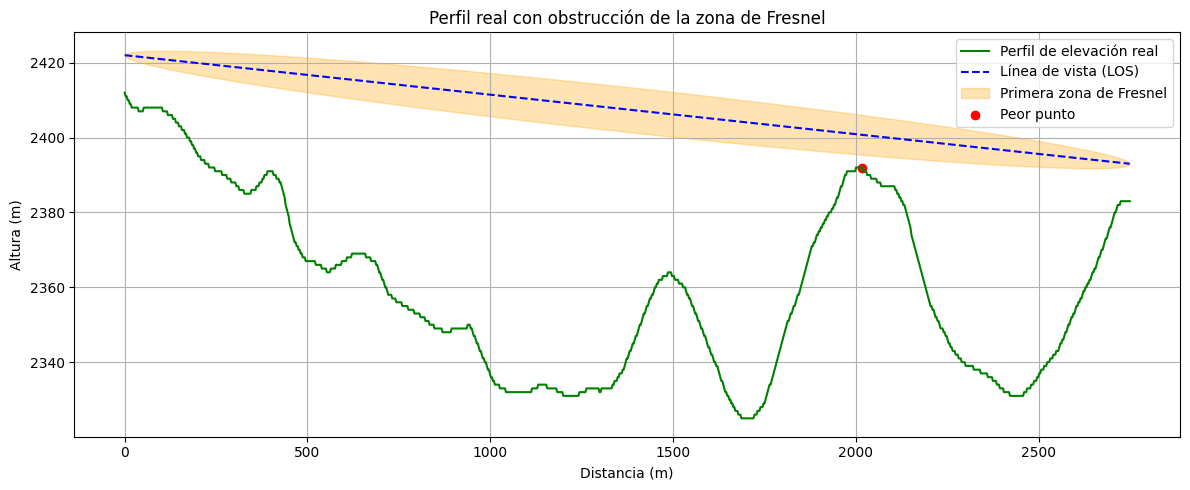

Index Peor Fresnel: 733
Distancia total = 2.75 Km
Peor Fresnel = 1.00F1
Radio de Fresnel en ese punto = 5.31 m
Espacio libre de la zona fresnel = 8.72 m
Azimut = 16.44º
Perdidas por espacio libre = 116.37dB
Angulo de Elevación = -0.60º
Obstrucción (difracción): 0.000 dB
Campo E = 98.117 dBμV/m
Nivel Rx = -62.571 dBm
Nivel Rx = 166.513 μV


In [ ]:
import requests
import math
import time
import matplotlib.pyplot as plt

# ------------------ FUNCIONES BÁSICAS ------------------

def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def fresnel_radius(d1, d2, f_ghz, n=1):
    C = 3e8  # Velocidad de la luz
    if d1 == 0 or d2 == 0:
        return 0
    lambda_m = C / (f_ghz * 1e9)
    return math.sqrt(n * lambda_m * d1 * d2 / (d1 + d2))

def obtener_perfil_elevacion(lat1, lon1, lat2, lon2, n_puntos=100, dataset="mapzen"):
    lats = [lat1 + i * (lat2 - lat1) / (n_puntos - 1) for i in range(n_puntos)]
    lons = [lon1 + i * (lon2 - lon1) / (n_puntos - 1) for i in range(n_puntos)]
    elevaciones = []
    batch_size = 100

    for i in range(0, n_puntos, batch_size):
        batch_lats = lats[i:i + batch_size]
        batch_lons = lons[i:i + batch_size]
        locations = "|".join([f"{lat},{lon}" for lat, lon in zip(batch_lats, batch_lons)])
        url = f"https://api.opentopodata.org/v1/{dataset}?locations={locations}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            elevaciones.extend([result["elevation"] for result in data["results"]])
        else:
            print(f"Error al consultar batch {i // batch_size + 1}")
            elevaciones.extend([None] * len(batch_lats))
        time.sleep(1)

    return list(zip(lats, lons, elevaciones))

def calcular_distancias_acumuladas(perfil):
    distancias = [0.0]
    for i in range(1, len(perfil)):
        lat1, lon1 = perfil[i - 1][:2]
        lat2, lon2 = perfil[i][:2]
        d = haversine(lat1, lon1, lat2, lon2)
        distancias.append(distancias[-1] + d)
    return distancias

# ------------------ LÓGICA DE ANÁLISIS ------------------

def calcular_los_line(elevaciones, tx_height, rx_height):
    return [
        elevaciones[0] + tx_height + i * (elevaciones[-1] + rx_height - (elevaciones[0] + tx_height)) / (len(elevaciones) - 1)
        for i in range(len(elevaciones))
    ]
    
def calcular_obstruccion_db_knife_edge(h, r):
    if r == 0:
        return 0
    v = math.sqrt(2) * h / r
    if v <= -0.78:
        return 0  # pérdida despreciable
    else:
        return 6.9 + 20 * math.log10(math.sqrt((v - 0.1)**2 + 1) + v - 0.1)

def detectar_peor_fresnel(elevaciones, los_line, distancias, freq_ghz):
    peores_puntos = []
    for i in range(1, len(elevaciones) - 1):
        d1 = distancias[i]
        d2 = distancias[-1] - d1
        r_fresnel = fresnel_radius(d1, d2, freq_ghz)
        centro_fresnel = los_line[i]
        borde_inferior = centro_fresnel - r_fresnel
        elevacion_terreno = elevaciones[i]
        #print(f"Index: {i}, Distancia: {d1}, Distancia entre LOS y Elevacion Terreno: {centro_fresnel-elevacion_terreno}")
        if elevacion_terreno > borde_inferior:
            penetracion = elevacion_terreno - borde_inferior
            pct_obstruccion = penetracion / r_fresnel
            
            h = elevacion_terreno - los_line[i]
            obstruccion_db = calcular_obstruccion_db_knife_edge(h, r_fresnel)
            #print(f"elevacion terreno:{elevacion_terreno:.3f}, hlos:{los_line[i]:.3f}, diferencia:{penetracion_obstruccion:.3f}, radiofresnel: {r_fresnel}")
        else:
            pct_obstruccion = 0
            obstruccion_db = 0

        peores_puntos.append((i, pct_obstruccion, r_fresnel, centro_fresnel - elevacion_terreno, obstruccion_db, d1, d2))
    # Selección inteligente:
    # Si hay obstrucción real, devuelve el punto con mayor obstrucción (dB),
    # si no, el punto con menor clearance (más cerca de tocar zona de Fresnel)
    peores_con_obstruccion = [p for p in peores_puntos if p[4] > 0]
    if peores_con_obstruccion:
        return max(peores_con_obstruccion, key=lambda x: x[4])  # por obstrucción dB
    else:
        return min(peores_puntos, key=lambda x: x[3])  # por menor clearance (más crítico)

# def detectar_peor_fresnel(elevaciones, los_line, distancias, freq_ghz):
#     peores_puntos = []

#     for i in range(1, len(elevaciones) - 1):
#         d1 = distancias[i]
#         d2 = distancias[-1] - d1
#         r_fresnel = fresnel_radius(d1, d2, freq_ghz)
#         centro_fresnel = los_line[i]
#         elevacion_terreno = elevaciones[i]

#         # h es la diferencia entre obstáculo y LOS (puede ser negativo)
#         h = elevacion_terreno - centro_fresnel
#         obstruccion_db = calcular_obstruccion_db_knife_edge(h, r_fresnel)

#         pct_obstruccion = max(0, h / r_fresnel) if r_fresnel > 0 else 0
#         clearance = centro_fresnel - elevacion_terreno

#         peores_puntos.append((i, pct_obstruccion, r_fresnel, clearance, obstruccion_db, d1, d2))

#     # Selección inteligente:
#     # Si hay obstrucción real, devuelve el punto con mayor obstrucción (dB),
#     # si no, el punto con menor clearance (más cerca de tocar zona de Fresnel)
#     peores_con_obstruccion = [p for p in peores_puntos if p[4] > 0]
#     if peores_con_obstruccion:
#         return max(peores_con_obstruccion, key=lambda x: x[4])  # por obstrucción dB
#     else:
#         return min(peores_puntos, key=lambda x: x[3])  # por menor clearance (más crítico)


def calcular_azimut(lat1, lon1, lat2, lon2):
    dlon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    x = math.sin(dlon) * math.cos(lat2)
    y = math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dlon)
    azimut_rad = math.atan2(x, y)
    azimut_deg = (math.degrees(azimut_rad) + 360) % 360
    return azimut_deg

def calcular_perdidas_espacio_libre(d_km, f_mhz):
    azimut = 20 * math.log10(d_km) + 20 * math.log10(f_mhz) + 32.44
    return azimut

def calcular_angulo_elevacion(h_tx_total, h_rx_total, d_total_m):
    delta_altura = h_rx_total - h_tx_total
    angulo_rad = math.atan2(delta_altura, d_total_m)
    return math.degrees(angulo_rad)

def calcular_campo_e(pot_transmisor, d_km):
    if d_km == 0:
        return 0
    return 106.9 + 10 * math.log10(pot_transmisor) - 20 * math.log10(d_km)

def calcular_nivel_rx_dbm(pot_transmisor, ganancia_tx, ganancia_rx, perdidas_linea, perdidas_espacio_libre, obstruccion_db=0):
    if pot_transmisor <= 0:
        raise ValueError("La potencia debe ser mayor que cero.")
    
    p_tx_dbm = 10 * math.log10(pot_transmisor) + 30
    return p_tx_dbm + ganancia_tx + ganancia_rx - perdidas_linea - perdidas_linea - perdidas_espacio_libre - obstruccion_db

def calcular_nivel_rx_uv(nivel_rx_dbm):
    return 10 ** ((nivel_rx_dbm + 107) / 20)

# ------------------ VISUALIZACIÓN ------------------

def graficar_perfil(distancias, elevaciones, los_line, freq_ghz, peor_index):
    plt.figure(figsize=(12, 5))
    plt.plot(distancias, elevaciones, label='Perfil de elevación real', color='green')
    plt.plot(distancias, los_line, label='Línea de vista (LOS)', linestyle='--', color='blue')
    
    # Zona de Fresnel
    zona_fresnel_inf = [los_line[i] - fresnel_radius(distancias[i], distancias[-1] - distancias[i], freq_ghz)
                        for i in range(len(distancias))]
    zona_fresnel_sup = [los_line[i] + fresnel_radius(distancias[i], distancias[-1] - distancias[i], freq_ghz)
                        for i in range(len(distancias))]

    plt.fill_between(distancias, zona_fresnel_inf, zona_fresnel_sup, color='orange', alpha=0.3, label='Primera zona de Fresnel')
    plt.scatter(distancias[peor_index], elevaciones[peor_index], color='red', label='Peor punto')
    plt.title("Perfil real con obstrucción de la zona de Fresnel")
    plt.xlabel("Distancia (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------ MAIN FLOW ------------------

def analizar_enlace(lat1, lon1, lat2, lon2, freq_ghz, freq_max_ghz, tx_height, rx_height, pot_transmisor, umbral_receptor, perdidas_linea, ganancia_tx, ganancia_rx, perdida_adicional_cable, sensibilidad_rx, n_puntos=100, dataset="mapzen"):
    global peor_fresnel, elevaciones, distancias, d1, d2
    perfil = obtener_perfil_elevacion(lat1, lon1, lat2, lon2, n_puntos, dataset)
    elevaciones = [p[2] for p in perfil]
    d_total = haversine(lat1, lon1, lat2, lon2)
    #distancias = [i * d_total / (n_puntos - 1) for i in range(n_puntos)]
    distancias = calcular_distancias_acumuladas(perfil)
    los_line = calcular_los_line(elevaciones, tx_height, rx_height)
    peor_index, peor_pct_obst, peor_fresnel, peor_clearance, obstruccion_db, d1, d2  = detectar_peor_fresnel(elevaciones, los_line, distancias, freq_ghz)
    azimut = calcular_azimut(lat1, lon1, lat2, lon2)
    perdidas_espacio_libre = calcular_perdidas_espacio_libre(d_total/1000, freq_ghz*1000)
    
    h_tx_total = elevaciones[0] + tx_height
    h_rx_total = elevaciones[-1] + rx_height
    angulo_elevacion = calcular_angulo_elevacion(h_tx_total, h_rx_total, d_total)
    campo_e = calcular_campo_e(pot_transmisor, d_total/1000)
    nivel_rx_dbm = calcular_nivel_rx_dbm(pot_transmisor, ganancia_tx, ganancia_rx, perdidas_linea, perdidas_espacio_libre, obstruccion_db=0)
    nivel_rx_uv = calcular_nivel_rx_uv(nivel_rx_dbm)

    graficar_perfil(distancias, elevaciones, los_line, freq_ghz, peor_index)
    print(f"Index Peor Fresnel: {peor_index}")
    print(f"Distancia total = {d_total/1000:.2f} Km")
    print(f"Peor Fresnel = {1-peor_pct_obst:.2f}F1")
    print(f"Radio de Fresnel en ese punto = {peor_fresnel:.2f} m")
    print(f"Espacio libre de la zona fresnel = {peor_clearance:.2f} m")
    print(f"Azimut = {azimut:.2f}º")
    print(f"Perdidas por espacio libre = {perdidas_espacio_libre:.2f}dB")
    print(f"Angulo de Elevación = {angulo_elevacion:.2f}º")
    print(f"Obstrucción (difracción): {obstruccion_db:.3f} dB")
    print(f"Campo E = {campo_e:.3f} dBμV/m")
    print(f"Nivel Rx = {nivel_rx_dbm:.3f} dBm")
    print(f"Nivel Rx = {nivel_rx_uv:.3f} μV")

# ------------------ EJECUCIÓN ------------------

analizar_enlace(
    lat1=7.357130556, #Grados
    lon1=-72.65921111, #Grados
    lat2=7.380841667, #Grados
    lon2=-72.65215833, #Grados
    freq_ghz=5.720, #GHZ
    freq_max_ghz = 5.720, #GHZ
    tx_height=10, #m
    rx_height=10, #m
    pot_transmisor = 1, #watts
    umbral_receptor = 0.75, #uV
    perdidas_linea = 0.1, #dB
    ganancia_tx = 12, #dBi
    ganancia_rx = 12, #dBi
    perdida_adicional_cable = 1, #dB/m
    sensibilidad_rx = 0, #dBm
    n_puntos=1000,
    dataset="mapzen"
)

#elevacion terreno:2392.000, hlos:2391.251, diferencia:0.749, radiofresnel: 5.318213193194261


In [262]:
import math

def calcular_valor(E19, E22, B28):
    numerador = 30 * E19 * E22
    denominador = B28 ** 2
    raiz = math.sqrt(numerador / denominador)
    resultado = 20 * math.log10(raiz / 1000) + 120.7
    return resultado

valor = calcular_valor(E19=1, E22=12, B28=2.749)
print(valor)

77.4795302108035


In [ ]:
def calcular_obstruccion_db_knife_edge(h, r):
    if r == 0:
        return 0
    v = math.sqrt(2) * h / r
    print(v)
    if v <= -0.78:
        return 0  # sin pérdidas perceptibles
    else:
        return 6.9 + 20 * math.log10(math.sqrt((v - 0.1)**2 + 1) + v - 0.1)
    
calcular_obstruccion_db_knife_edge(-5.087, 5.31)

-1.3548219193581799


-3.2576164616747203